In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

# Load the dataset
data = pd.read_csv('diabetes_data.csv')

# Drop unnecessary column
data.drop(columns=['Unnamed: 0'], inplace=True)

# Display initial data overview
print("Initial Data Overview:")
print(data.info())
print(data.head())



Initial Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Fasting_Blood_Glucose       3000 non-null   float64
 1   Postprandial_Blood_Glucose  3000 non-null   float64
 2   HbA1c                       3000 non-null   float64
 3   Random_Blood_Glucose        3000 non-null   float64
 4   BMI                         3000 non-null   float64
 5   Waist_Circumference         3000 non-null   float64
 6   Triglyceride_Levels         3000 non-null   float64
 7   Blood_Pressure_Systolic     3000 non-null   float64
 8   Blood_Pressure_Diastolic    3000 non-null   float64
 9   LDL_Cholesterol             3000 non-null   float64
 10  HDL_Cholesterol             3000 non-null   float64
 11  CRP_Levels                  3000 non-null   float64
 12  Insulin_Levels              3000 non-null   float64
 13  HOMA_IR   

In [4]:
# Convert categorical columns before imputation
categorical_columns = ['Family_History_of_Diabetes', 'Physical_Activity', 'Diet', 'Smoking', 'Alcohol_Consumption',
                       'Obesity', 'Sleep_Apnea', 'Gestational_Diabetes', 'PCOS', 'Hypertension', 'Diabetes_Status']

for col in categorical_columns:
    data[col] = data[col].astype(str)
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

# Separate numeric and categorical columns
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Impute missing values for numeric columns
imputer = SimpleImputer(strategy='mean')
data[numeric_columns] = imputer.fit_transform(data[numeric_columns])

print("Data after handling missing values and encoding categorical variables.")


Data after handling missing values and encoding categorical variables.


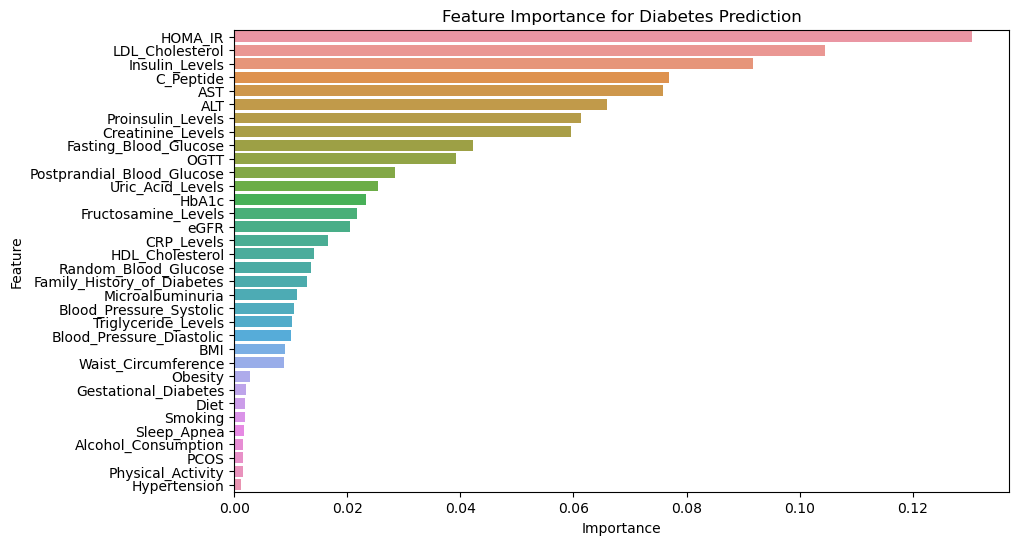

Top 10 Selected Features:
                  Feature  Importance
13                HOMA_IR    0.130510
9         LDL_Cholesterol    0.104420
12         Insulin_Levels    0.091740
22              C_Peptide    0.076869
21                    AST    0.075847
20                    ALT    0.065893
23      Proinsulin_Levels    0.061270
15      Creatinine_Levels    0.059497
0   Fasting_Blood_Glucose    0.042204
14                   OGTT    0.039274


In [5]:
# Feature selection using RandomForest
features = data.drop(columns=['Diabetes_Status'])
target = data['Diabetes_Status']

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(features, target)

# Feature importance
feature_importances = pd.DataFrame({'Feature': features.columns, 'Importance': rf_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importance for Diabetes Prediction')
plt.show()

# Print top features
print("Top 10 Selected Features:")
print(feature_importances.head(10))

# Select top features
selected_features = feature_importances['Feature'].head(10).tolist()
X = data[selected_features]
y = target


In [6]:
# Handle class imbalance using SMOTE
print("Class distribution before balancing:", y.value_counts())

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Class distribution after balancing:", pd.Series(y_resampled).value_counts())

# Feature scaling
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)


Class distribution before balancing: Diabetes_Status
1.0    1664
0.0    1336
Name: count, dtype: int64
Class distribution after balancing: Diabetes_Status
1.0    1664
0.0    1664
Name: count, dtype: int64


In [7]:
# Model selection with cross-validation
models = {
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42),
    'SVM': SVC(kernel='linear', C=1.0, random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42)
}

for model_name, model in models.items():
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_resampled_scaled, y_resampled, cv=cv, scoring='accuracy')
    print(f"{model_name} Accuracy: {np.mean(scores):.4f}")


RandomForest Accuracy: 0.9147
SVM Accuracy: 0.9059
LogisticRegression Accuracy: 0.9084


In [8]:
# Train best model
best_model = RandomForestClassifier(n_estimators=200, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_resampled_scaled, y_resampled, test_size=0.2, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print("Final Model Performance")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Final Model Performance
Accuracy: 0.9054054054054054
[[285  43]
 [ 20 318]]
              precision    recall  f1-score   support

         0.0       0.93      0.87      0.90       328
         1.0       0.88      0.94      0.91       338

    accuracy                           0.91       666
   macro avg       0.91      0.90      0.91       666
weighted avg       0.91      0.91      0.91       666



In [11]:
# Step 2: Filter only diabetic individuals and classify Type 1 vs Type 2
diabetic_data = data[data['Diabetes_Status'] == 1].copy()

print("Initial diabetic data shape:", diabetic_data.shape)

# Check unique Insulin Levels and C-Peptide values
print("Unique Insulin Levels:", diabetic_data['Insulin_Levels'].unique())
print("Unique C-Peptide Levels:", diabetic_data['C_Peptide'].unique())

diabetic_data['Diabetes_Type'] = diabetic_data.apply(lambda row:
    'Type 1' if (row['Insulin_Levels'] <= 2 and row['C_Peptide'] <= 0.2) else
    'Type 2' if (10 <= row['Insulin_Levels'] <= 50 and 0.6 <= row['C_Peptide'] <= 3.0) else
    'Unknown', axis=1)

print("Diabetes type distribution before filtering:")
print(diabetic_data['Diabetes_Type'].value_counts())

diabetic_data = diabetic_data[diabetic_data['Diabetes_Type'] != 'Unknown']
print("Diabetes type distribution after filtering:")
print(diabetic_data['Diabetes_Type'].value_counts())

diabetic_data['Diabetes_Type'] = LabelEncoder().fit_transform(diabetic_data['Diabetes_Type'])

features_step2 = ['BMI', 'Insulin_Levels', 'C_Peptide', 'HOMA_IR', 'Fasting_Blood_Glucose',
                  'Postprandial_Blood_Glucose', 'Family_History_of_Diabetes', 'Physical_Activity']

X2 = diabetic_data[features_step2]
y2 = diabetic_data['Diabetes_Type']

print("Class distribution before SMOTE:")
print(y2.value_counts())

# Apply SMOTE for class balancing
if len(y2.unique()) > 1:
    print("Applying SMOTE as multiple classes are present.")
    smote = SMOTE(random_state=42)
    X2_resampled, y2_resampled = smote.fit_resample(X2, y2)
else:
    print("Skipping SMOTE as only one class is present.")
    X2_resampled, y2_resampled = X2, y2

print("Class distribution after SMOTE:")
print(pd.Series(y2_resampled).value_counts())

X2_scaled = scaler.fit_transform(X2_resampled)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_scaled, y2_resampled, test_size=0.2, random_state=42)

model_step2 = RandomForestClassifier(n_estimators=100, random_state=42)
model_step2.fit(X2_train, y2_train)
y2_pred = model_step2.predict(X2_test)

print("Step 2 - Type 1 vs Type 2 Diabetes Classification")
print("Accuracy:", accuracy_score(y2_test, y2_pred))
print(classification_report(y2_test, y2_pred))


Initial diabetic data shape: (1664, 35)
Unique Insulin Levels: [33.40670343 13.63183095 39.13660863 27.37692098 46.54251497 22.5800676
 43.75099356 48.07205031 17.79856187 44.52433618 31.96593924  5.48875115
 42.16211459 21.21051659 29.69226265 43.03601401 48.76364123  4.9014523
 29.1283163  16.84490618 38.33656965 44.08869316 28.0901079  13.43659584
 28.74651416 31.92837488 19.17040472 42.53146939 23.75838746 36.86918519
  6.58573797 49.19558895 40.80609389 15.33267437 17.83115883 33.2175469
 38.33574846 37.97727722 26.4739547  40.91938582 22.97974797  7.94626713
 47.71046646 40.06369527 29.77763109 33.0466717  46.6669773  17.90691867
 48.90759512 43.44527041 17.50609206 47.97532754 21.4069967  44.01579597
 11.08909893 28.29779891  3.15014649 38.68258322 29.88386712 32.02830001
  4.48260236 12.12983985 32.11707237 29.17692725 31.38319144 28.36406103
 15.10538219  8.57886481 42.755402   31.59100921 10.9525286  43.90570887
 37.65108146 49.01363663 40.2674996  16.48540271 42.68311022 16.